In [ ]:
import zipfile
import os

# Path to archive file (update filename as needed)
archive_path = '/content/archive.zip'
extract_dir = '/content/waste_dataset'

# Create extract destination folder if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract all contents
with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Dataset extracted to:", extract_dir)


Dataset extracted to: /content/waste_dataset


# EDA

### 1. Imports and Directory Setup

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

base_dir = '/content/waste_dataset/Garbage_Dataset_Classification/images'
category_list = sorted(os.listdir(base_dir))
print("Categories:", category_list)


Categories: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


### 2. Class Distribution

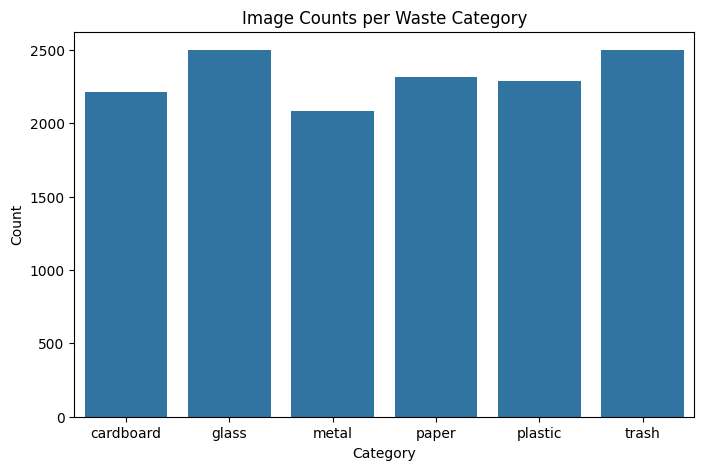

In [ ]:
class_counts = {cat: len(os.listdir(os.path.join(base_dir, cat))) for cat in category_list}

plt.figure(figsize=(8,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Image Counts per Waste Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


### 3. Sample Image Visualization

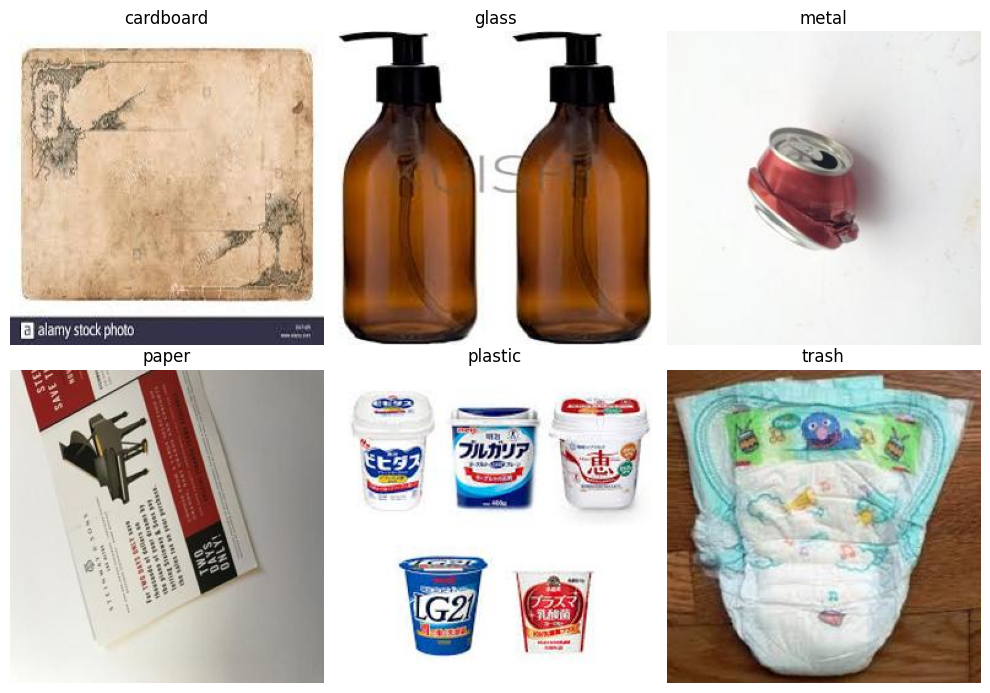

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7))
for idx, cat in enumerate(category_list):
    path = os.path.join(base_dir, cat, os.listdir(os.path.join(base_dir, cat))[0])
    img = Image.open(path)
    axs[idx//3, idx%3].imshow(img)
    axs[idx//3, idx%3].set_title(cat)
    axs[idx//3, idx%3].axis('off')
plt.tight_layout()
plt.show()


### 4. Metadata Inspection

In [ ]:
meta_path = '/content/waste_dataset/Garbage_Dataset_Classification/metadata.csv'
metadata = pd.read_csv(meta_path)
print(metadata.head())
print(metadata.info())


              filename      label
0  cardboard_02038.jpg  cardboard
1  cardboard_02320.jpg  cardboard
2  cardboard_01728.jpg  cardboard
3  cardboard_00093.jpg  cardboard
4  cardboard_00094.jpg  cardboard
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13901 entries, 0 to 13900
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  13901 non-null  object
 1   label     13901 non-null  object
dtypes: object(2)
memory usage: 217.3+ KB
None


### Image Size and Aspect Ratio Distribution


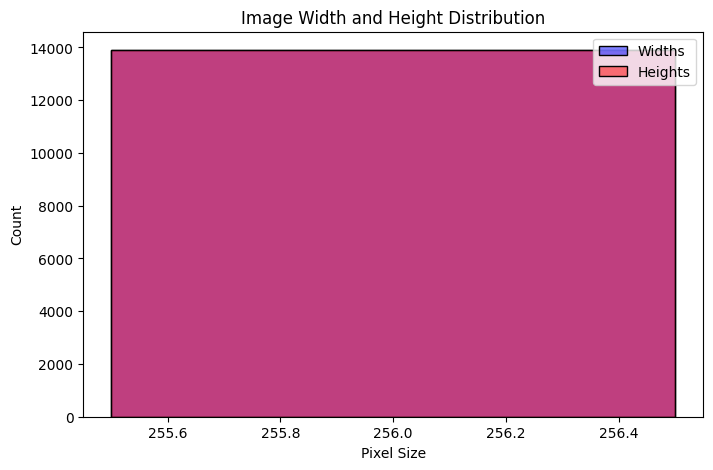

In [ ]:
import numpy as np

image_shapes = []
for cat in category_list:
    for img_name in os.listdir(os.path.join(base_dir, cat)):
        img_path = os.path.join(base_dir, cat, img_name)
        img = Image.open(img_path)
        image_shapes.append(img.size)

widths, heights = zip(*image_shapes)
plt.figure(figsize=(8,5))
sns.histplot(widths, label='Widths', color='blue', kde=True)
sns.histplot(heights, label='Heights', color='red', kde=True)
plt.legend()
plt.title('Image Width and Height Distribution')
plt.xlabel('Pixel Size')
plt.ylabel('Count')
plt.show()


### Check for Corrupted Images

In [ ]:
corrupted = []
for cat in category_list:
    for img_name in os.listdir(os.path.join(base_dir, cat)):
        try:
            img_path = os.path.join(base_dir, cat, img_name)
            img = Image.open(img_path)
            img.verify()  # Will not load pixel data but checks for corruption
        except Exception as e:
            corrupted.append(img_path)
print("Corrupted file count:", len(corrupted))


Corrupted file count: 0


### Visualize Images Per Category with Mean RGB Values

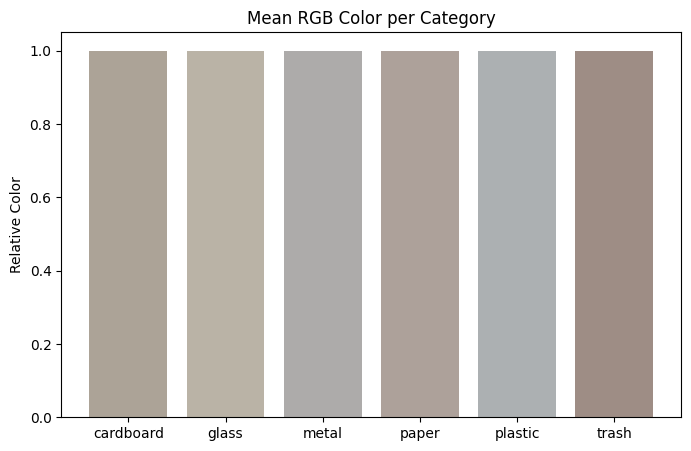

In [ ]:
mean_colors = []
for cat in category_list:
    img_files = os.listdir(os.path.join(base_dir, cat))[:50]  # sample 50 per class
    rgb_sums = np.zeros(3)
    for img_name in img_files:
        img_path = os.path.join(base_dir, cat, img_name)
        img = Image.open(img_path).convert('RGB')
        rgb = np.mean(np.array(img).reshape(-1,3), axis=0)
        rgb_sums += rgb
    mean_color = rgb_sums / len(img_files)
    mean_colors.append(mean_color)

plt.figure(figsize=(8,5))
for i, color in enumerate(mean_colors):
    plt.bar(category_list[i], 1, color=np.array(color)/255.0)
plt.title('Mean RGB Color per Category')
plt.ylabel('Relative Color')
plt.show()


# Data Preprocessing


Step 1: Import libraries and set up paths

In [ ]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Original dataset directory (images with category folders)
original_dir = '/content/waste_dataset/Garbage_Dataset_Classification/images'

# Create new directories for splitted data
base_dir = '/content/waste_dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for d in [train_dir, val_dir, test_dir]:
    if not os.path.exists(d):
        os.makedirs(d)


Step 2: Function to create class subfolders and split files

In [ ]:
def split_data(source_dir, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.15, 0.15), seed=42):
    random.seed(seed)
    categories = os.listdir(source_dir)

    for category in categories:
        category_path = os.path.join(source_dir, category)
        if not os.path.isdir(category_path):
            continue

        files = os.listdir(category_path)
        random.shuffle(files)

        n_total = len(files)
        n_train = int(split_ratio[0] * n_total)
        n_val = int(split_ratio[1] * n_total)

        # Create subfolders in target dirs
        for folder in [train_dir, val_dir, test_dir]:
            class_folder = os.path.join(folder, category)
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)

        # Copy files for train set
        for file in files[:n_train]:
            shutil.copy2(os.path.join(category_path, file), os.path.join(train_dir, category, file))

        # Copy files for val set
        for file in files[n_train:n_train+n_val]:
            shutil.copy2(os.path.join(category_path, file), os.path.join(val_dir, category, file))

        # Copy files for test set
        for file in files[n_train+n_val:]:
            shutil.copy2(os.path.join(category_path, file), os.path.join(test_dir, category, file))


Step 3: Execute dataset splitting


In [ ]:
split_data(original_dir, train_dir, val_dir, test_dir)
print("Dataset split into train, val, and test sets.")


Dataset split into train, val, and test sets.


Step 4: Create ImageDataGenerators for augmented training and normalized validation/test


In [ ]:
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,           # Increase rotation for broader angle variety
    width_shift_range=0.3,       # More shifting for object positioning
    height_shift_range=0.3,
    shear_range=0.3,             # Higher shearing for perspective distortion
    zoom_range=0.3,              # Larger zoom range for scale variations
    horizontal_flip=True,
    vertical_flip=True,          # Add vertical flips for more symmetry
    brightness_range=(0.5, 1.5), # Adjust brightness for lighting variety
    channel_shift_range=50,      # Stronger color channel shift
    fill_mode='reflect'          # Use 'reflect' for natural edge filling
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Convert generators to tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, img_height, img_width, 3], [None, num_classes])
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, img_height, img_width, 3], [None, num_classes])
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, img_height, img_width, 3], [None, num_classes])
)

Found 9728 images belonging to 6 classes.
Found 2084 images belonging to 6 classes.
Found 2089 images belonging to 6 classes.


Step 5: Check class indices and batch shapes

In [ ]:
print("Classes:", train_generator.class_indices)
x_batch, y_batch = next(train_generator)
print("Batch shape:", x_batch.shape, y_batch.shape)


Classes: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Batch shape: (32, 224, 224, 3) (32, 6)


This workflow will split your dataset into 70% training, 15% validation, and 15% test sets, apply data augmentation to training data, and normalize validation and test sets. The data will be loaded batch-wise for model training effortlessly.

# Model Development

Step 1: Import required libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam


Step 2: Load MobileNetV2 base model (without top classification layers)


In [ ]:
img_height, img_width = 224, 224
num_classes = len(train_generator.class_indices)  # Number of waste categories

base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')


base_model.trainable = True

# Freeze all layers except the last n layers
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False



Step 3: Add classification head layers on top

In [ ]:
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)


Step 4: Compile the model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Step 5: Model summary to verify architecture

In [ ]:
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 1,534,086 (5.85 MB)

 Non-trainable params: 731,584 (2.79 MB)

# Model training

Step 1: Import required callback class

In [ ]:
from tensorflow.keras.callbacks import Callback


Step 2: Define custom callback for printing metrics after each epoch


In [ ]:
class EpochRunCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(
            f"Epoch {epoch+1}: "
            f"loss={logs['loss']:.4f}, accuracy={logs['accuracy']:.4f}, "
            f"val_loss={logs['val_loss']:.4f}, val_accuracy={logs['val_accuracy']:.4f}"
        )


Step 3: Create the callback instance

In [ ]:
epoch_callback = EpochRunCallback()


Step 4: Train the model using this callback

In [ ]:
epochs = 30

# Calculate steps per epoch and validation steps manually
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[epoch_callback]
)

Epoch 1/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.6368 - loss: 1.0257Epoch 1: loss=0.8489, accuracy=0.6993, val_loss=3.9528, val_accuracy=0.6067
304/304 ━━━━━━━━━━━━━━━━━━━━ 168s 480ms/step - accuracy: 0.6370 - loss: 1.0252 - val_accuracy: 0.6067 - val_loss: 3.9528
Epoch 2/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.7709 - loss: 0.6601Epoch 2: loss=0.6296, accuracy=0.7790, val_loss=1.9828, val_accuracy=0.7451
304/304 ━━━━━━━━━━━━━━━━━━━━ 207s 685ms/step - accuracy: 0.7709 - loss: 0.6600 - val_accuracy: 0.7451 - val_loss: 1.9828
Epoch 3/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7967 - loss: 0.5621Epoch 3: loss=0.5553, accuracy=0.7995, val_loss=1.7036, val_accuracy=0.7939
304/304 ━━━━━━━━━━━━━━━━━━━━ 193s 636ms/step - accuracy: 0.7967 - loss: 0.5621 - val_accuracy: 0.7939 - val_loss: 1.7036
Epoch 4/30
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8148 - loss: 0.5234Epoch 4: loss=0.5220, accuracy=0.8160, val_loss=2.2528, val_a

# Model Evaluation

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


 1/66 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.8750 - loss: 1.0725

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.9048 - loss: 0.5260
Test Loss: 0.4294
Test Accuracy: 0.9205


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


Generate predictions and extract true labels

In [ ]:
test_generator.reset()  # Reset generator for prediction
y_true = test_generator.classes  # True class labels

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class indices

class_labels = list(test_generator.class_indices.keys())  # Class names


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


Print classification report and calculate F1-score

In [ ]:
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Weighted F1-score: {f1:.4f}")


Classification Report:
               precision    recall  f1-score   support

   cardboard       0.95      0.87      0.91       333
       glass       0.97      0.91      0.94       375
       metal       0.89      0.96      0.92       314
       paper       0.92      0.93      0.92       348
     plastic       0.84      0.93      0.89       344
       trash       0.95      0.93      0.94       375

    accuracy                           0.92      2089
   macro avg       0.92      0.92      0.92      2089
weighted avg       0.92      0.92      0.92      2089

Weighted F1-score: 0.9209


Plot confusion matrix heatmap

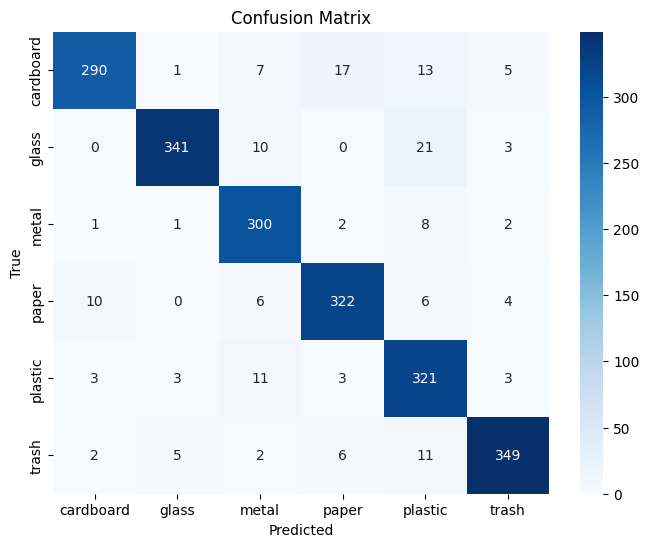

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Saving the model

In [ ]:
# Save the entire model to an HDF5 file
model.save('waste_classifier_mobilenetv2.h5')

print("Model saved to waste_classifier_mobilenetv2.h5")


Model saved to waste_classifier_mobilenetv2.h5


In [ ]:
model.save('chetan_bisht.h5')
print("Model saved to waste_classifier_mobilenetv2")

Model saved to waste_classifier_mobilenetv2
